In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import plotly.graph_objects as go
import seaborn as sns
import os
os.chdir("sampletree")

In [2]:
rng = np.random.default_rng()

class node():
    def __init__(self, name: str):
        self.name = name
        self.cnt = None
    
    def get_value(self):
        return self.cnt
        
    def __repr__(self):
        return self.name
    
class layer():
    def __init__(self, name : str, nl: int, distribution = None):
        global rng
        self.nl = nl
        self.nodes = []
        self.name = name
        self.rng = rng
        self.max_N_leaves = 10000
        if distribution is not None:
            self.distribution = distribution
        else:
            def distribution_default(node: node) -> float:
                m = node + 2
                n = m/(m-1)
                p = 1/m
                #p = 0.1
                return self.rng.negative_binomial(n,p)
            
            self.distribution = distribution_default
    
    def sample(self, previous_layer) -> None:
        if len(previous_layer) < self.max_N_leaves:
            previous_nodes = previous_layer.nodes
        else:
            previous_nodes = np.random.choice(previous_layer.nodes, size=self.max_N_leaves, replace=False)
        for node in previous_nodes:
            for _ in range(self.nl):
                self.nodes.append(self.distribution(node))
    @property
    def sorted_nodes(self):
        return np.sort(self.nodes)[::-1]
    
    @property
    def array_nodes(self):
        return np.array(self.nodes)
    
    @property
    def average(self):
        return np.average(self.nodes)
      
    def __len__(self):
        return len(self.nodes)
   
    def __repr__(self):
        return f"{self.name}, nodes: {self.nodes}"
    
class first_layer(layer): 
    def sample(self, previous_layer):
        raise NotImplementedError("First layer cannot have a previous layer")
            
    def sample(self) -> None:
        for node in range(self.nl):
            self.nodes.append(self.distribution(10))

In [147]:
L = 50
nl = 3
layers = [first_layer("l0", nl)]
layers[0].sample()
for il,l in enumerate(range(L)):
    if il % (L/10) == 0:
        print(il)
    new_layer = layer(f"l{il+1}", nl)
    new_layer.distribution = lambda node: round(new_layer.rng.normal(node,10))
    layers.append(new_layer)
    new_layer.sample(layers[il])

0
5
10
15
20
25
30
35
40
45


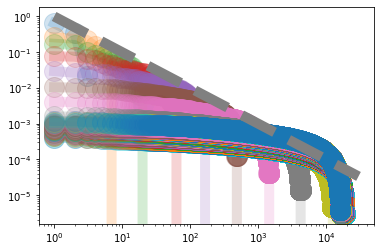

In [148]:
for l in range(L+1):
    freqs = layers[l].sorted_nodes
    x = np.linspace(1, len(freqs), len(freqs))
    plt.plot(x, freqs/np.sum(freqs), marker="o", ms=20, lw=10, alpha=0.2)

plt.plot(x, 1/x, lw=10, ls="--", c="gray")

plt.xscale("log")
plt.yscale("log")

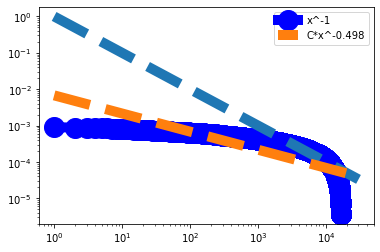

In [149]:
#freqs = np.sort(np.concatenate([l.sorted_nodes for l in layers]).ravel())[::-1]
#
#plt.plot(x, freqs/np.sum(freqs), marker="o", ms=20, c="gray", lw=10, label="x^-1")

layer_of_interest = layers[29]
cnts = layer_of_interest.sorted_nodes/np.sum(layer_of_interest.sorted_nodes)
plt.plot(np.linspace(1, len(layer_of_interest), len(layer_of_interest)), cnts, marker="o", ms=20, c="blue", lw=10, label="x^-1")

x = np.linspace(1, len(layer_of_interest), len(layer_of_interest))
plt.plot(x, 1/x, lw=10, ls="--")

popt, pcov = curve_fit(lambda x, C, gamma: C * np.power(x, - gamma), x[5:], cnts[5:])
plt.plot(x, popt[0]*np.power(x,-popt[1]), lw=10, ls="--", label=f"C*x^-{round(popt[1],3)}")


plt.xscale("log")
plt.yscale("log")
#plt.ylim(1e-5,5e-1)
plt.legend()

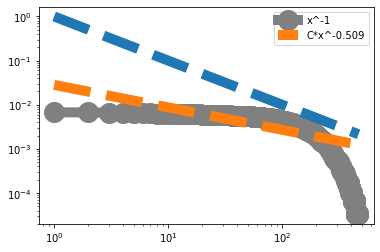

In [150]:
freqs = np.sort(np.unique(layers[-1].nodes,return_counts=True)[1])[::-1]
x = np.linspace(1, len(freqs), len(freqs))
plt.plot(x, freqs/np.sum(freqs), marker="o", ms=20, c="gray", lw=10, label="x^-1")

plt.plot(x, 1/x, lw=10, ls="--")

popt, pcov = curve_fit(lambda x, C, gamma: C * np.power(x, - gamma), x[5:], (freqs/np.sum(freqs))[5:])
plt.plot(x, popt[0]*np.power(x,-popt[1]), lw=10, ls="--", label=f"C*x^-{round(popt[1],3)}")


plt.xscale("log")
plt.yscale("log")
#plt.ylim(1e-5,5e-1)
plt.legend()

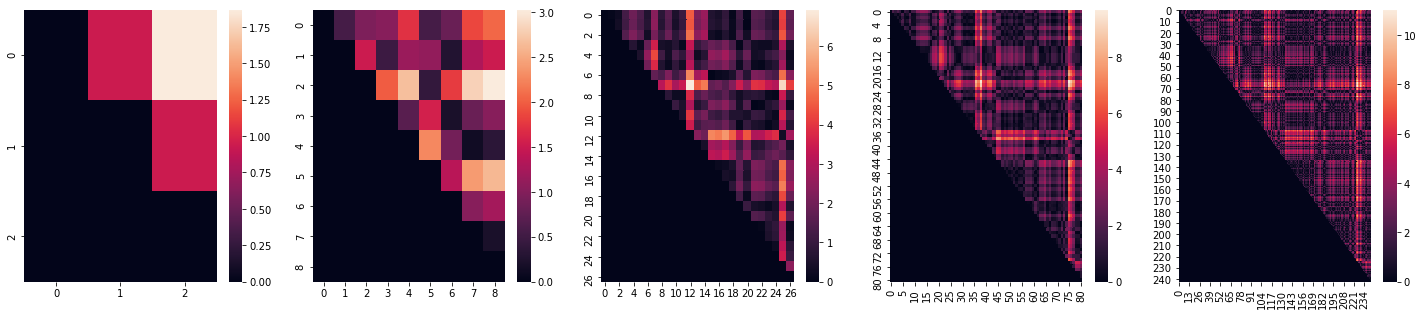

In [151]:
fig,axs = plt.subplots(1,5, figsize=(25,5))
for i,ax in enumerate(axs):
    leaves = layers[i].nodes
    sns.heatmap(list(map(lambda leafA: list(map(lambda leafB: abs(leafA[1]-leafB[1])/np.average(leaves) if leafA[0] < leafB[0] else 0, enumerate(leaves))), enumerate(leaves))), ax=ax)

In [152]:
avgs = [np.median(np.abs(l.array_nodes[1:]-l.array_nodes[:-1]))/l.average for l in layers]

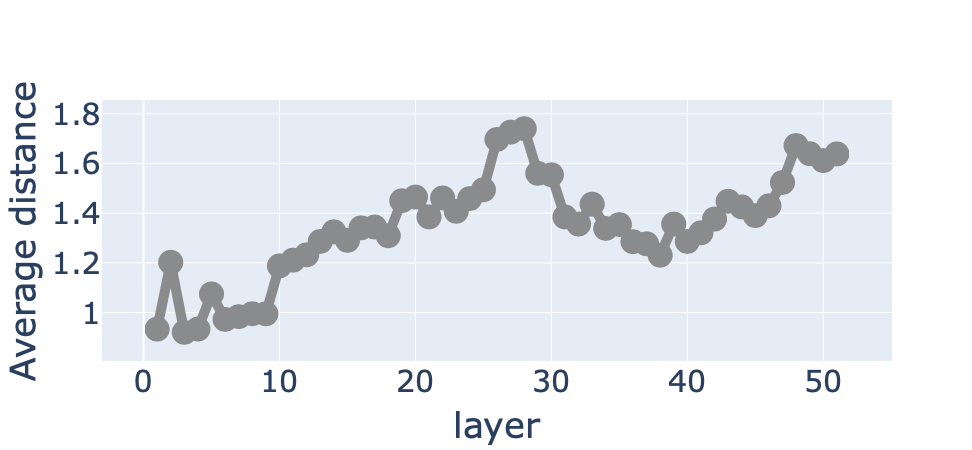

In [153]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(1,len(layers),len(layers)), y=avgs, marker=dict(size=25, symbol="0"), line=dict(width=10, color="gray"), mode="lines+markers"))

fig.update_traces(line_width=10, opacity=0.9)
fig.update_layout(showlegend=False,
                 xaxis = dict(title="layer", title_font_size=35, tickfont_size=30),
                 yaxis = dict(title="Average distance", title_font_size=35, tickfont_size=30),
              )
fig.show()
fig.write_image("distance_layer_negativem2.pdf")

## Statistics

In [8]:
import multiprocessing as mp
L = 50
nl = 3
avgs = []
variances = [1,2,3,4,5,7,10,15,20,25,50,75,80,90,95,99,100,110,120,125,150,200,500,1000]
nls = [2,3,4,5,6,7,8,9,10]

def run(nl):
    avgs_tmp = []
    layers = [first_layer("l0", nl)]
    layers[0].sample()
    previous_layer = None
    for il,l in enumerate(range(L)):
        if (1+il) % (L/2) == 0:
            print("{} step: {}".format(nl,il))
        if previous_layer is None:
            previous_layer = first_layer("l0", nl)
            #previous_layer.distribution = lambda node: previous_layer.rng.normal(node, variance)
            previous_layer.sample()
            continue
        else:
            new_layer = layer(f"l{il+1}", nl)
            #new_layer.distribution = lambda node: new_layer.rng.normal(node, variance)
            new_layer.sample(previous_layer)
            previous_layer = new_layer
    return np.mean(np.abs(new_layer.array_nodes[1:]-new_layer.array_nodes[:-1]))/new_layer.average

avgs_tmp = []
def collect(avg):
    global avgs_tmp
    avgs_tmp.append(avg)

def whatswrong(err):
    print(err)

for nl in nls:
#for variance in variances:
    avgs_tmp = []
    pool = mp.Pool(4)
    works = [pool.apply_async(run, args=([nl]), callback=collect, error_callback=whatswrong) for istat in range(10)]
    
    for w in works:
        w.get()
        
    pool.close()
    pool.join()        
    avgs.append(np.average(avgs_tmp, axis=0))

2 step: 24
2 step: 24
2 step: 24
2 step: 24
2 step: 49
2 step: 49
2 step: 49
2 step: 49
2 step: 24
2 step: 24
2 step: 24
2 step: 24
2 step: 49
2 step: 49
2 step: 49
2 step: 49
2 step: 24
2 step: 24
2 step: 49
2 step: 49
3 step: 24
3 step: 24
3 step: 24
3 step: 24
3 step: 493 step: 49

3 step: 49
3 step: 49
3 step: 24
3 step: 24
3 step: 24
3 step: 24
3 step: 49
3 step: 49
3 step: 49
3 step: 49
3 step: 24
3 step: 24
3 step: 49
3 step: 49
4 step: 24
4 step: 244 step: 24

4 step: 24
4 step: 49
4 step: 49
4 step: 49
4 step: 49
4 step: 24
4 step: 24
4 step: 24
4 step: 24
4 step: 49
4 step: 49
4 step: 49
4 step: 49
4 step: 24
4 step: 24
4 step: 49
4 step: 49
5 step: 24
5 step: 24
5 step: 245 step: 24

5 step: 49
5 step: 49
5 step: 49
5 step: 49
5 step: 24
5 step: 24
5 step: 24
5 step: 24
5 step: 49
5 step: 49
5 step: 49
5 step: 49
5 step: 24
5 step: 24
5 step: 49
5 step: 49
6 step: 24
6 step: 246 step: 24

6 step: 24
6 step: 49
6 step: 49
6 step: 49
6 step: 49
6 step: 24
6 step: 24
6 step: 24

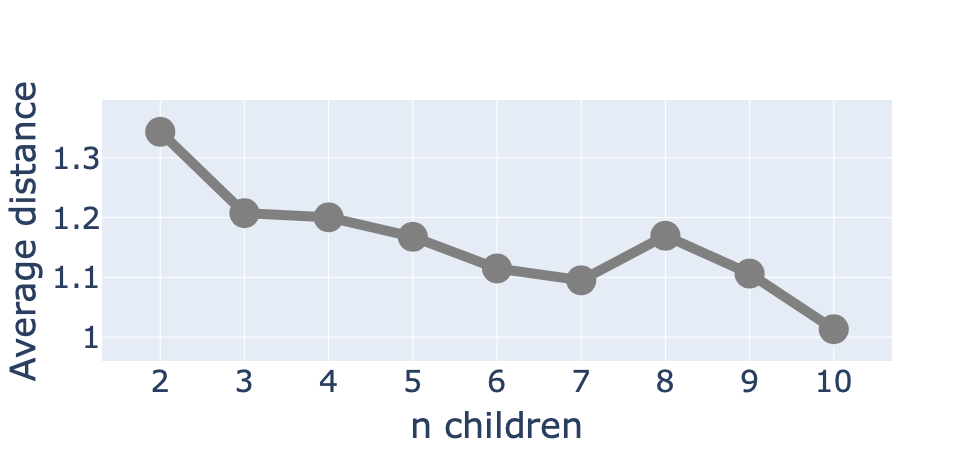

In [9]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=nls, y=avgs, marker=dict(size=30, symbol="0"), line=dict(width=10, color="gray"), mode="lines+markers"))

fig.update_traces(line_width=10)
fig.update_layout(showlegend=False,
                 xaxis = dict(title="n children", title_font_size=35, tickfont_size=30),
                 yaxis = dict(title="Average distance", title_font_size=35, tickfont_size=30),
              )
fig.show()
fig.write_image("distance_nl.pdf")